# **Machine Learning**

The problem is that an A/B test does not look at a perspective of the real world that involves changes and effect.


The target variable is the repsonse given by the users who responded to the BIO data.

In [1]:
# Import your necessary dependencies and modules
from scipy import stats
from sklearn import linear_model
from xgboost import XGBClassifier
from IPython.display import Image  
from sklearn.feature_selection import RFE
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing,metrics,model_selection
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor, export_graphviz
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,mean_squared_error,mean_squared_error, r2_score, mean_absolute_error

# Import required libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms


import math
import pydotplus
import sklearn

#set seaborn style
sns.set(style="darkgrid")

plt.style.use('ggplot')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Import the data into a dataframe called data through github link. 
#Set low memory to false because the dataset is large.

url = 'https://raw.githubusercontent.com/mwi-kali/10-Academy/master/AB%20Hypothesis%20Testing%3A%20Ad%20campaign%20performance/data/AdSmartABdata.csv'

data = pd.read_csv(url, low_memory = False)

In [3]:
#function to wrangle the data set

def clean(dataset):
  # unique ID so not generalizer
  del dataset['auction_id'] 
  
  #remove where there are no reponses
  dataset = dataset[(dataset['yes']==1) | (dataset['no']==1)].copy()

  #get the day
  dataset.loc[:,'DOW'] = dataset.loc[:,'date'].str.slice(start=8, stop=10)
  dataset.loc[:,'DOW'] = pd.to_numeric(dataset.loc[:,'DOW'])
  
  #drop the column
  del dataset['date'],dataset['device_make']

  dataset.loc[:,'experiment'] = np.where(dataset.experiment == 'exposed', 1, 0)

  browsers = {np.nan:0, 'Chrome Mobile':1,'Chrome Mobile WebView':2,'Chrome':3,'Chrome Mobile iOS':4,'Mobile Safari':5,'Mobile Safari UI/WKWebView':6,'Opera Mini':7,'Opera Mobile':8,'Samsung Internet':9,'Edge Mobile':10,'Android':11, 'Firefox Mobile':12, 'Facebook':13,'Pinterest':14,'Puffin':15}
  
  dataset.loc[:,'browser'] = dataset.loc[:,'browser'].map(browsers).values

  dataset.loc[:,'response'] = np.where(dataset.yes == 1, 1, 0)

  del dataset['yes'],dataset['no']
  
  # Remove missing data
  dataset.dropna(inplace=True)

  return dataset

In [4]:
data = clean(data)

In [5]:
#Copy of the data for feature engineering
data_eng = data.copy()

In [6]:
#set the independent variables (represented as X) and the dependent variable (represented as y)
X = data_eng[['experiment', 'hour', 'browser', 'platform_os','DOW']]
y = data_eng['response']

# Feature extraction
model = LogisticRegression()
rfe = RFE(model, 2)
fit = rfe.fit(X, y)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))


Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 2 3 1 4]


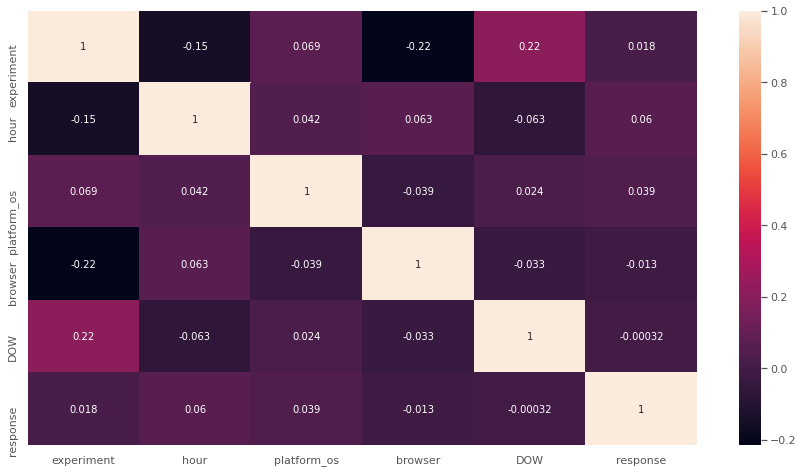

In [7]:
#Using a heatmat to visualize
corr = data_eng.corr()
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr,annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### **Split Data**

In [8]:
#set the independent variables (represented as X) and the dependent variable (represented as y)
X = data[['experiment', 'hour', 'platform_os']]
y = data['response']

#70% training, 20% validation, and 10% test sets
x_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=(2/9), random_state=1)

Training a machine learning model using 5-fold cross validation.

In [9]:
kfold = KFold(n_splits=5)

In [10]:
for train_index, test_index in kfold.split(X):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_validate = X_train, X_validate
      y_train, y_validate = y_train, y_validate, 

Train: [ 249  250  251  252  253  254  255  256  257  258  259  260  261  262
  263  264  265  266  267  268  269  270  271  272  273  274  275  276
  277  278  279  280  281  282  283  284  285  286  287  288  289  290
  291  292  293  294  295  296  297  298  299  300  301  302  303  304
  305  306  307  308  309  310  311  312  313  314  315  316  317  318
  319  320  321  322  323  324  325  326  327  328  329  330  331  332
  333  334  335  336  337  338  339  340  341  342  343  344  345  346
  347  348  349  350  351  352  353  354  355  356  357  358  359  360
  361  362  363  364  365  366  367  368  369  370  371  372  373  374
  375  376  377  378  379  380  381  382  383  384  385  386  387  388
  389  390  391  392  393  394  395  396  397  398  399  400  401  402
  403  404  405  406  407  408  409  410  411  412  413  414  415  416
  417  418  419  420  421  422  423  424  425  426  427  428  429  430
  431  432  433  434  435  436  437  438  439  440  441  442  443  444

## **Machine Learning Application to Training Data**

#### **Helper functions**

In [11]:
#evaluation scores related to a regression problem
def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('RMSE Score: {}'.format(rmse))
    print('R2_Squared: {}'.format(r_sq))
    print('MAE Score: {}'.format(mae))

In [12]:
#plotting the original values and values predicted by the model
def plot_preds(y_test, y_preds, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5))
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue')
    prediction = plt.scatter(np.arange(1, N+1), y_preds, c='red')
    plt.xticks(np.arange(1, N+1))
    plt.xlabel('# Oberservation')
    plt.ylabel('Enrollments')
    title = 'True labels vs. Predicted Labels ({})'.format(model_name)
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()

#### **Logistic Regression** 

In [13]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg = logreg.fit(X_train,y_train)

# predict
y_pred=logreg.predict(X_test)

In [14]:
scores = model_selection.cross_val_score(logreg, X_validate, y_validate, cv=kfold)
print("Accuracy: %.2f%%" % (scores.mean()*100.0)) 
print("Degree polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Accuracy: 41.77%
Degree polynomial MSE: 0.4177142857142857, STD: 0.046577563136719596


In [15]:
calculate_metrics(y_test, y_pred)

RMSE Score: 0.6693280212272604
R2_Squared: -0.8181818181818177
MAE Score: 0.448


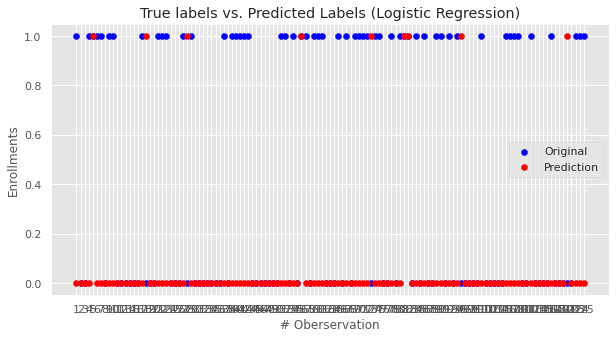

In [16]:
plot_preds(y_test, y_pred, 'Logistic Regression')

In [17]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.93      0.70        70
           1       0.44      0.07      0.12        55

    accuracy                           0.55       125
   macro avg       0.50      0.50      0.41       125
weighted avg       0.51      0.55      0.45       125



The classification report displays the Precision, Recall , F1  and Support scores for the model.

Precision score means the the level up-to which the prediction made by the model is precise. The precision for the user to be aware of the brand is 0.56 and for the user not to be aware of the brand is 0.44.

Recall is the amount up-to which the model can predict the outcome. Recall for the user not to be aware of the brand is 0.93 and for the user to be aware of the brand is 0.07. F1 and Support scores are the amount of data tested for the predictions. In the dataset the data tested for the user not to be aware of the brand is 70 and for the user to be aware of the brand is 55.

Text(0.5, 257.44, 'Predicted label')

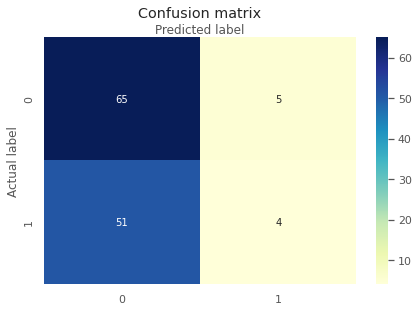

In [19]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

*Confusion Matrix Evaluation Metrics*

In [20]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.552
Precision: 0.4444444444444444
Recall: 0.07272727272727272


*ROC Curve*

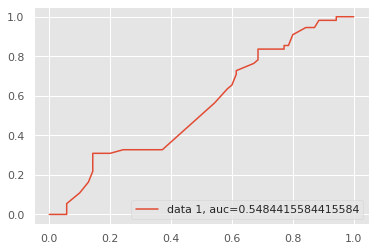

In [21]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

AUC score for the case is 0.5484. AUC score 1 represents perfect classifier, and 0.5 represents a worthless classifier.

#### **Decision Trees**


In [22]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=5)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [23]:
scores = model_selection.cross_val_score(clf, X_validate, y_validate, cv=kfold)
print("Accuracy: %.2f%%" % (scores.mean()*100.0)) 
print("Degree polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Accuracy: 51.01%
Degree polynomial MSE: 0.5101224489795919, STD: 0.02539602201515202


In [24]:
calculate_metrics(y_test, y_pred)

RMSE Score: 0.6752777206453653
R2_Squared: -0.8506493506493502
MAE Score: 0.456


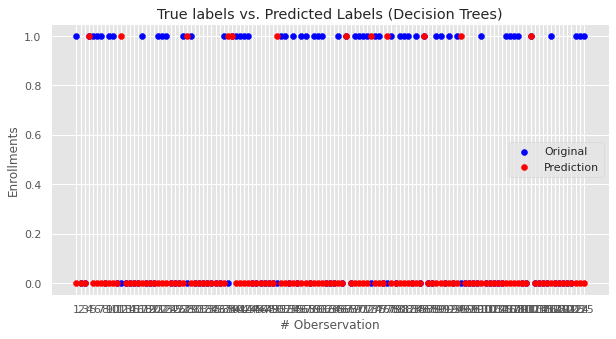

In [25]:
plot_preds(y_test, y_pred, 'Decision Trees')

*Visualizing Decision Trees*

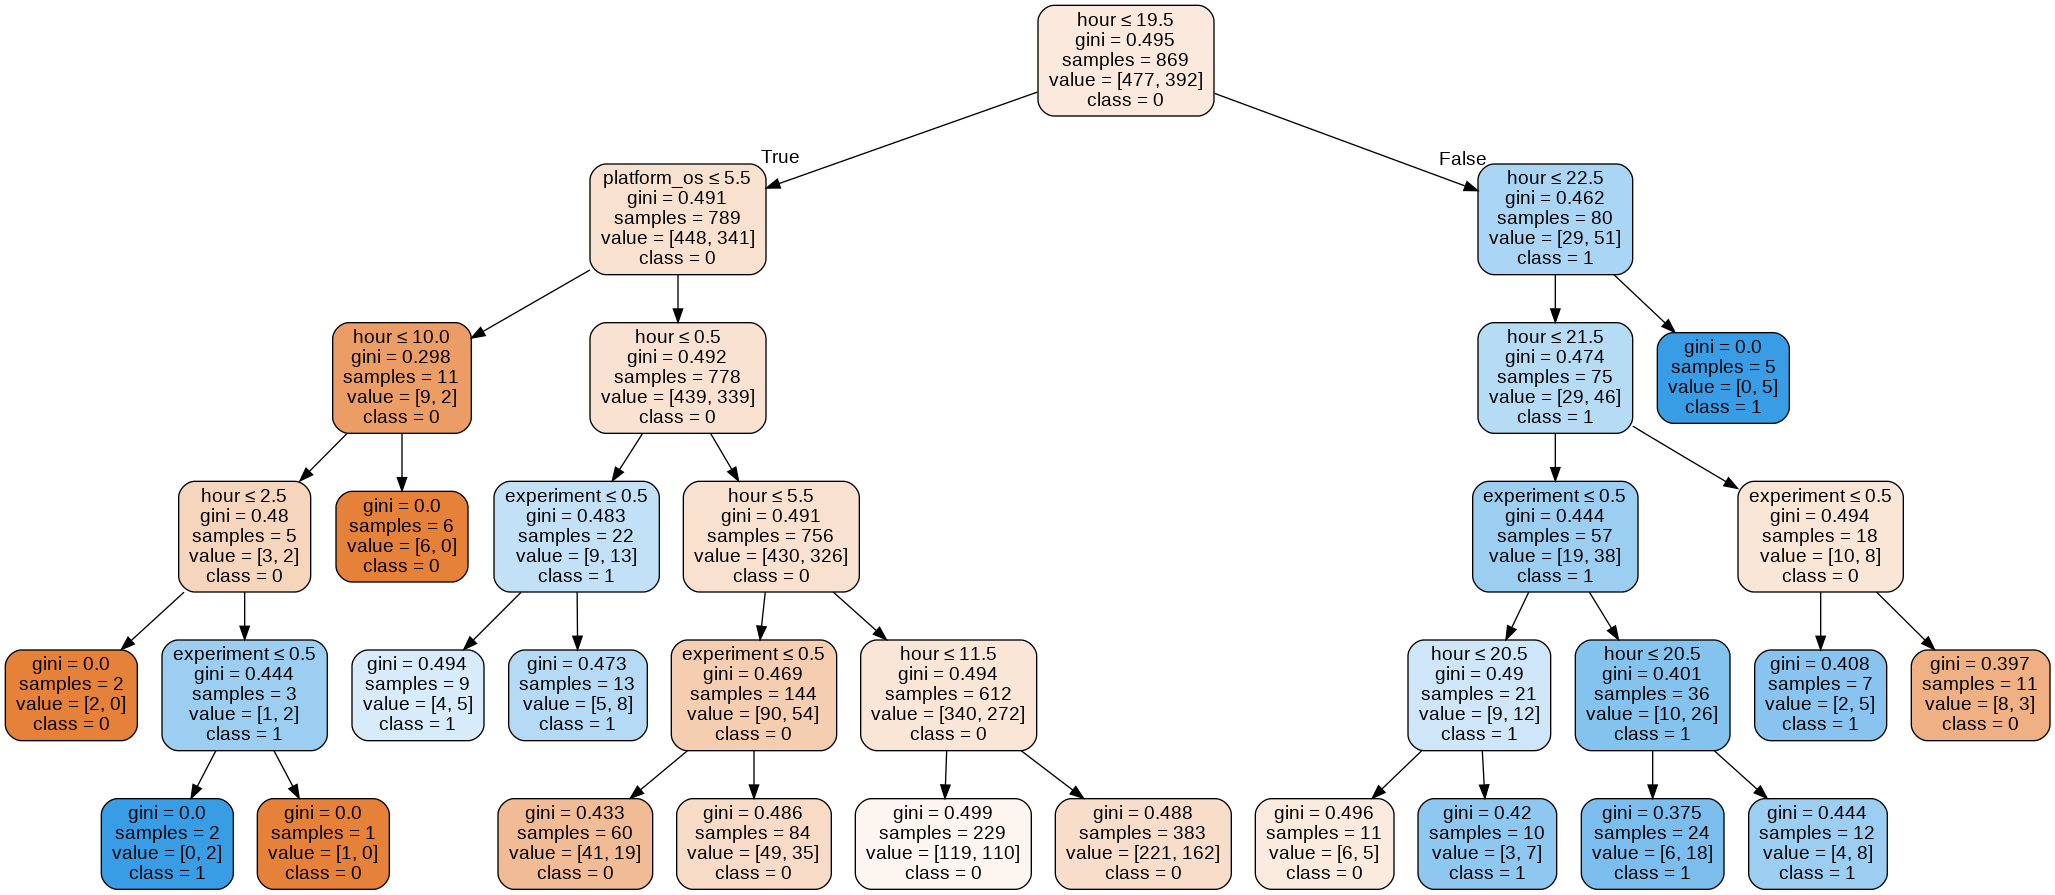

In [26]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = ['experiment', 'hour', 'platform_os'],class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('ad.png')
Image(graph.create_png())

*Confusion Matrix Evaluation Metrics*

In [27]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.544
Precision: 0.4166666666666667
Recall: 0.09090909090909091


#### **Decision Tree Regression**

In [28]:
# Create Decision Tree Regressor object
dtreg = DecisionTreeRegressor(max_depth=5)

# Train Decision Tree Regressor
dtreg = dtreg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dtreg.predict(X_test)
y_pred = np.round_(y_pred)

In [29]:
scores = model_selection.cross_val_score(dtreg, X_validate, y_validate, cv=kfold)
print("Accuracy: %.2f%%" % (scores.mean()*100.0)) 
print("Degree polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

Accuracy: -12.21%
Degree polynomial MSE: 0.12206641198290828, STD: 0.029163722719440177


In [30]:
calculate_metrics(y_test, y_pred)

RMSE Score: 0.6752777206453653
R2_Squared: -0.8506493506493502
MAE Score: 0.456


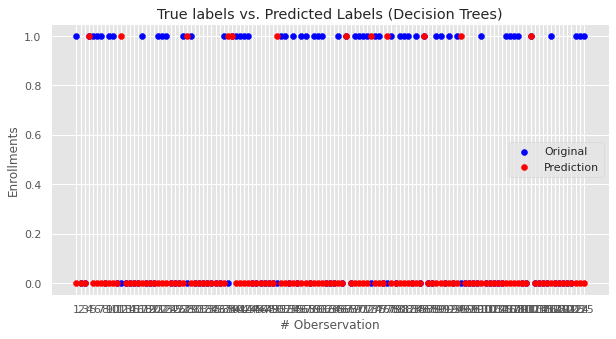

In [31]:
plot_preds(y_test, y_pred, 'Decision Trees')

*Visualizing Decision Trees*

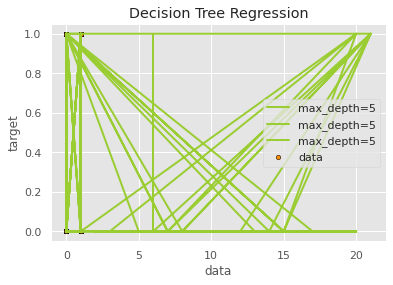

In [32]:
# Plot the results
plt.figure()
plt.scatter(X['experiment'], y, s=20, edgecolor="black",c="darkorange", label="data")
plt.plot(X_test, y_pred, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

*Confusion Matrix Evaluation Metrics*

In [33]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.544
Precision: 0.4166666666666667
Recall: 0.09090909090909091


#### **XGBoost** 

In [34]:
# Create XGBoost Classifier object
xg_reg = xgb.XGBRegressor(max_depth = 5)

#train the model
xg_reg = xg_reg.fit(X_train,y_train)

#predict
y_pred = xg_reg.predict(X_test)
y_pred = np.round_(y_pred)

[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [35]:
scores = model_selection.cross_val_score(xg_reg, X_validate, y_validate, cv=kfold)
print("Accuracy: %.2f%%" % (scores.mean()*100.0)) 
print("Degree polynomial MSE: " + str(np.mean(np.abs(scores))) + ", STD: " + str(np.std(scores)))

[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: -16.75%
Degree polynomial MSE: 0.16752705634876602, STD: 0.10528593518611216


In [36]:
calculate_metrics(y_test, y_pred)

RMSE Score: 0.7042726744663603
R2_Squared: -1.0129870129870127
MAE Score: 0.496


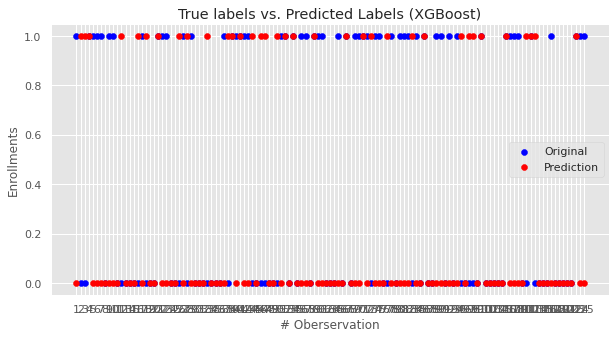

In [37]:
plot_preds(y_test, y_pred, 'XGBoost')

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 0.704273


*Visualizing XGBoost*

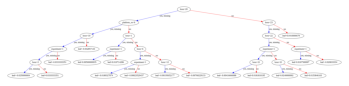

In [39]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

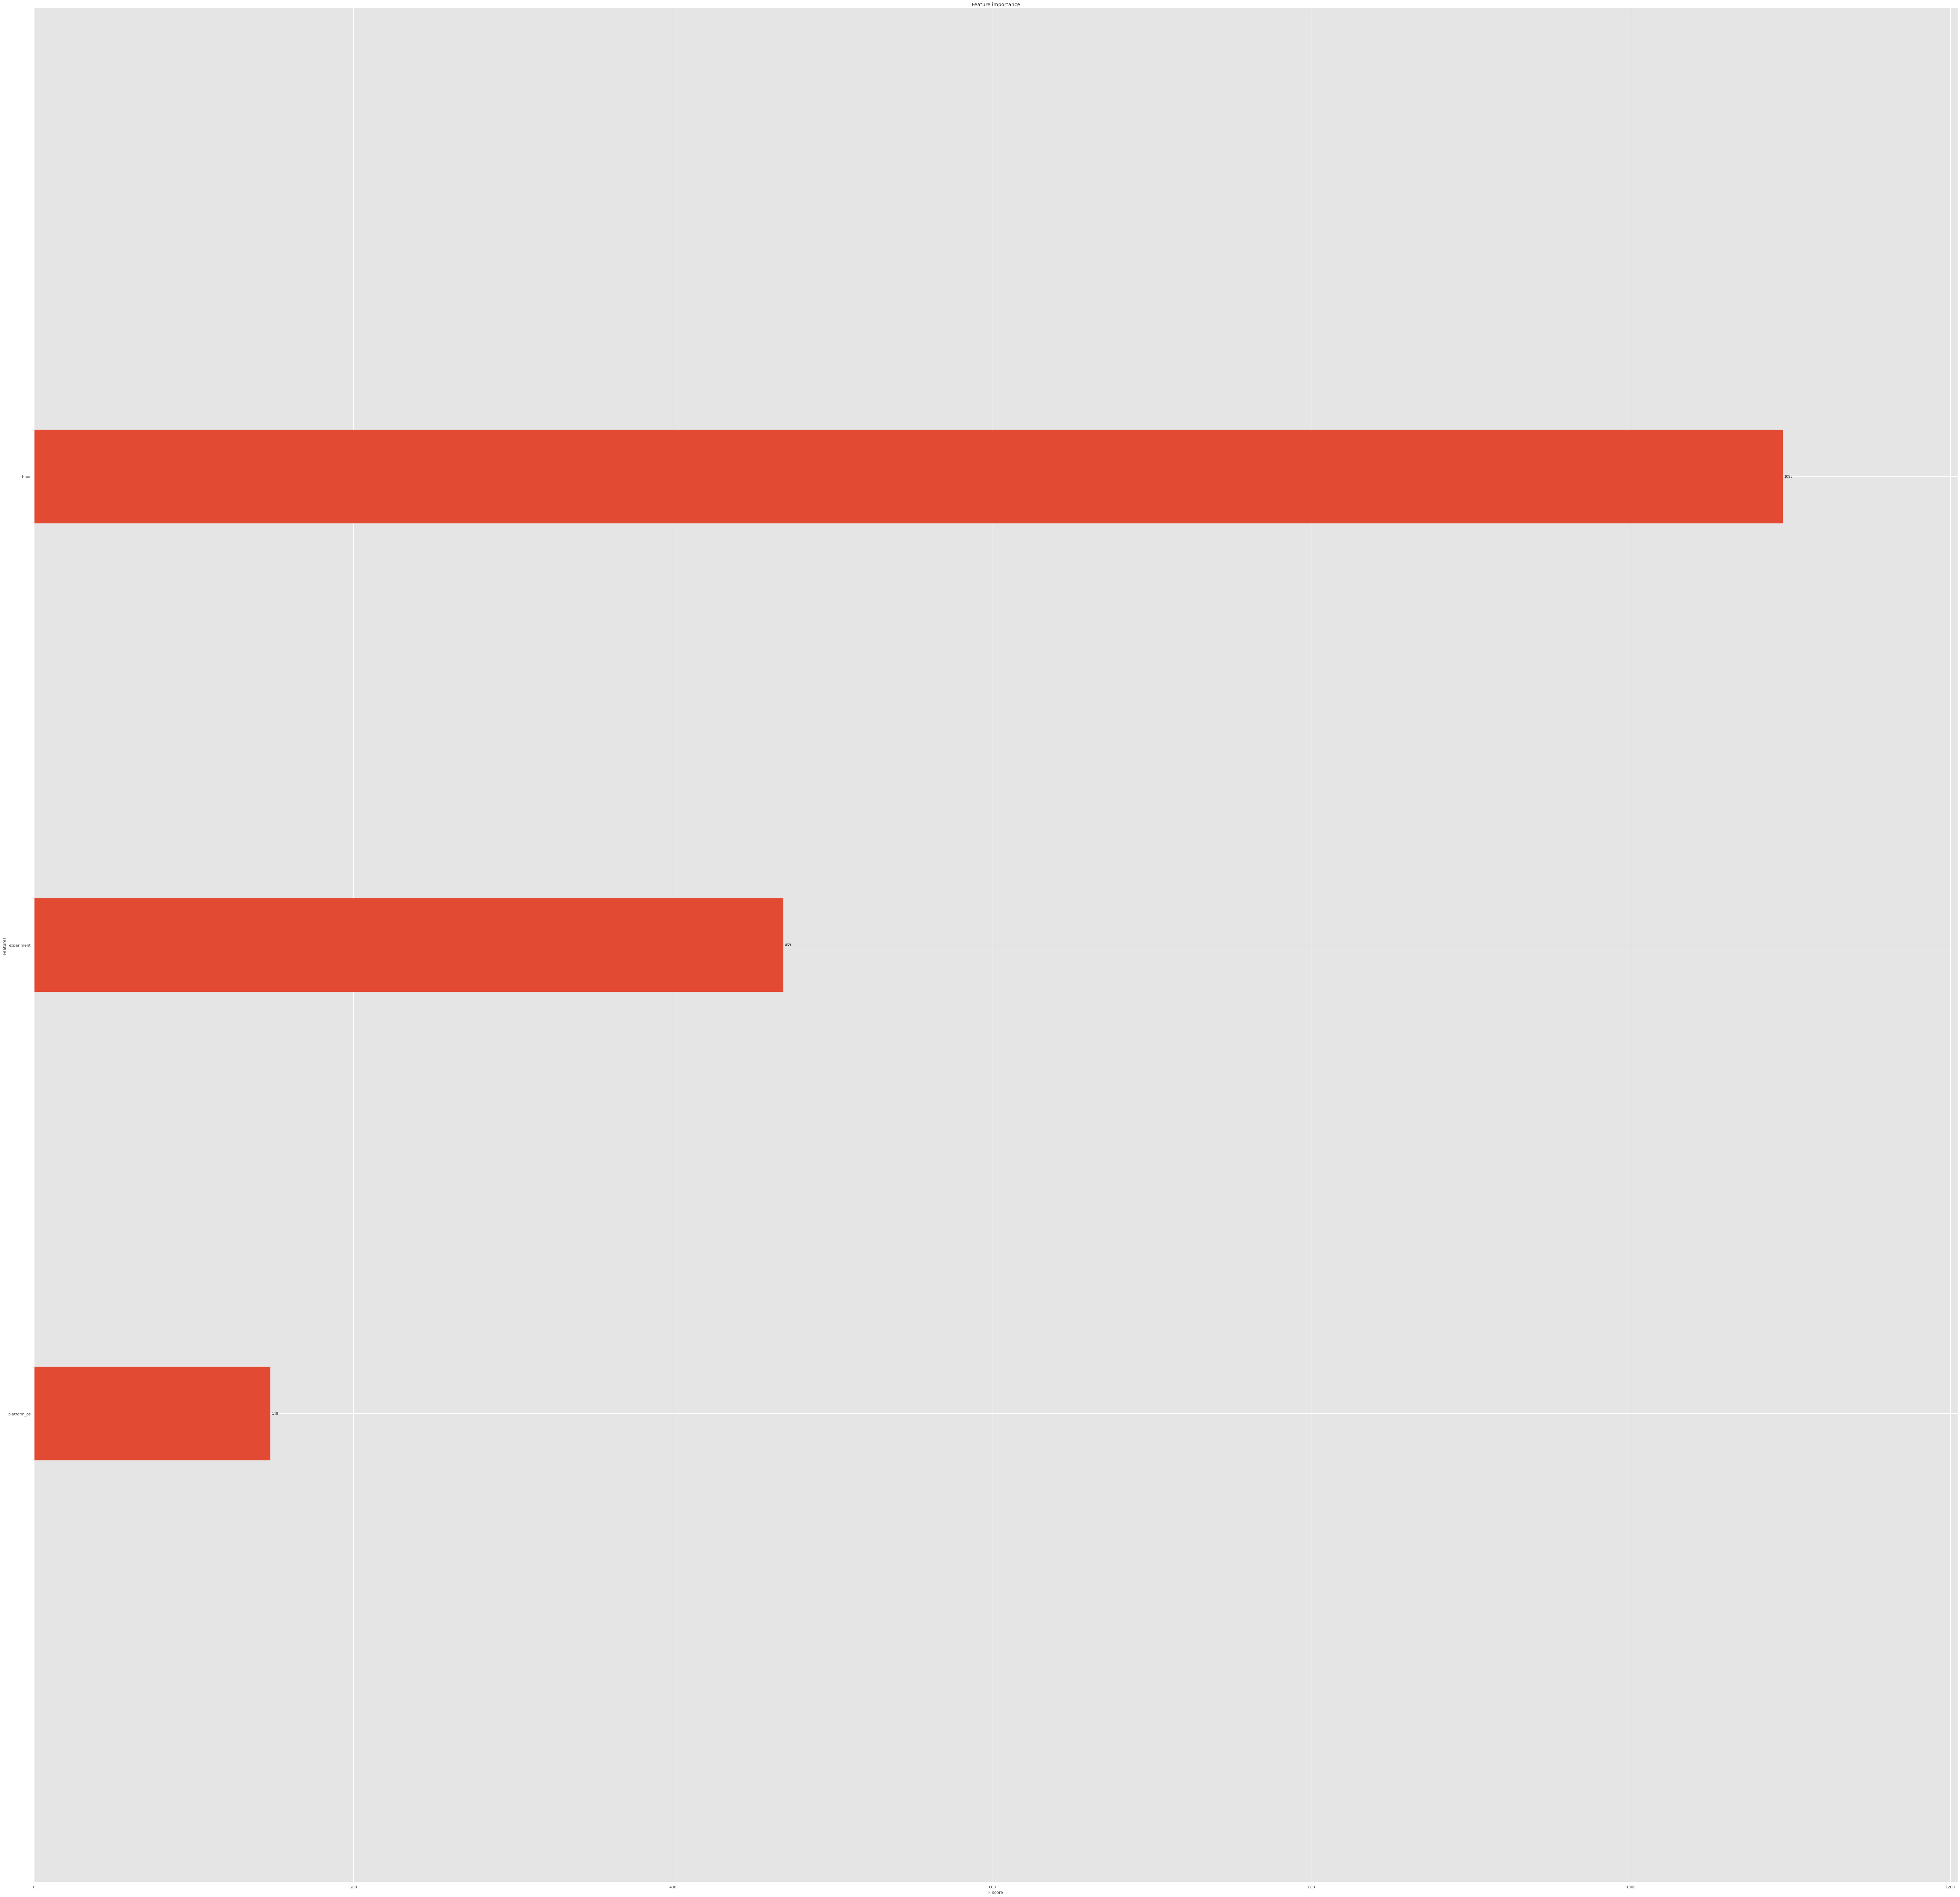

In [40]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Confusion Matrix Evaluation Metrics

In [41]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.504
Precision: 0.4
Recall: 0.2545454545454545
